# INSTRUCTIONS PROVIDED:

## PRODUCTION:
Dataset containing PLC information on the processing settings at COIL-DATE-MT level.
1. `COIL ID`: of the metal coil processed
1. `MT`:meter observation of the coil (i.e. one observation every 7 meters)
1. `DATE`: day of the year in which the processing of a given COIL-MT started
1. `TIME_START_PROCESS`: time in which the processing started 
1. All the remaining fields are settings refering to the processing of a given COIL-MT.

Hint: check the reliability of the MT variable.

## DEFECTS:
Dataset containing information on the detected defect by coil and type of defect.

This information are gathered during quality control processes after the production.
1. `COIL ID`: of the metal coil processed
1. `MT_FROM`: point of the coil in which a given defect start.
1. `MT_TO`: point in which a given defect end.
1. `DATE`: date in which the coil has been processed.
1. `DIF_TIPO_1`(to6): indicator for the kind of of defect detected.

In [108]:
#imports here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, ParameterGrid, RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score, make_scorer, hamming_loss, precision_score, recall_score, f1_score, confusion_matrix, log_loss
from sklearn.inspection import PartialDependenceDisplay
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline
import shap
from statsmodels.stats.outliers_influence import variance_inflation_factor
from joblib import Memory
from sklearn.multioutput import MultiOutputClassifier
import csv
from xgboost import XGBClassifier
random_state = 42
test_size = 0.4
cv=3
cachedir = Memory(location='cache_directory', verbose=0)

import warnings
warnings.simplefilter("ignore")

In [2]:
#loading data
path_production= '/Users/mattia/Library/CloudStorage/OneDrive-Personal/BBS/05 Machine learnign/00 Fieldwork/4_MANUFACTURING_ROOT CAUSE/RC_PRODUCTION_clean.csv'
path_defects='/Users/mattia/Library/CloudStorage/OneDrive-Personal/BBS/05 Machine learnign/00 Fieldwork/4_MANUFACTURING_ROOT CAUSE/RC_DEFECTS_clean.csv'
production = pd.read_csv(path_production)
defects = pd.read_csv(path_defects, sep=';')

Creating the `MT_REVIEWED` column and substitute with the `MT` for correcting the data issues

In [3]:
production.sort_values(by=['COIL', 'DATE', 'TIME_START_PROCESS'], inplace=True)
production['MT_REVIEWED'] = production.groupby(['COIL'])['MT'].transform(lambda x: np.arange(start=0, stop=len(x)*7, step=7))
production.drop(columns=['MT'], inplace=True)
column_change=production.pop('MT_REVIEWED')
production.insert(2, 'MT_REVIEWED',column_change)
production.head()

,COIL,DATE,MT_REVIEWED,TIME_START_PROCESS,SPEED_PROCESS,TEMP_Z1,TEMP_Z2,TEMP_Z3,TEMP_Z4,TEMP_Z5,...,SPZ2_R4,SPZ1_R1_ASS,SPZ1_R2_ASS,TIRO_DECAP,SPEED_FILL,FILL_FORZA,FILL_TIRO,FILL_ALL,FILL_BENDING_POS,FILL_BENDING_NEG
0,240627,2019-03-15,0,14:25:23.060,16.934625,671.967562,679.751438,688.119187,716.717250,734.616563,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,240627,2019-03-15,7,14:25:53.060,16.773638,668.635875,676.207125,681.034500,710.093250,729.040500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,240627,2019-03-15,14,14:26:23.060,11.142165,669.105375,677.042625,678.493125,707.967750,727.783500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,240627,2019-03-15,21,14:27:08.060,11.148851,671.631750,681.066000,679.704750,707.241375,727.886250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,240627,2019-03-15,28,14:27:38.060,15.657188,675.052875,686.972813,683.336250,710.432437,730.182375,...,530.110125,14.625,14.625,1956.40875,NaN,NaN,NaN,NaN,NaN,NaN


## Merging 2 dataframes
For the merging we looked for keeping all the rows of the production df

In [4]:
# This code creates the new dataframe with the defect information applied to the relevant meter ranges.
merged_df = production.copy()
for i in range(1, 7):
    defect_col = f'DIF_TIPO_{i}'
    merged_df[defect_col] = 0 # or use np.nan, or 0, depending on how you want to represent no defect

def apply_defects(row, production, merged_df):
    coil_id = row['COIL']
    mt_from = row['MT_FROM']
    mt_to = row['MT_TO']
    defect_info = row[['DIF_TIPO_1', 'DIF_TIPO_2', 'DIF_TIPO_3', 'DIF_TIPO_4', 'DIF_TIPO_5', 'DIF_TIPO_6']]
    
    # Filter production for the current coil and meter range
    mask = (production['COIL'] == coil_id) & (production['MT_REVIEWED'] >= mt_from) & (production['MT_REVIEWED'] <= mt_to)
    production_subset = production.loc[mask]
    
    # Update the merged DataFrame with defect information
    for index in production_subset.index:
        merged_df.loc[index, defect_info.index] = defect_info.values

# Apply defects to the production DataFrame
_=defects.apply(lambda row: apply_defects(row, production, merged_df), axis=1)

## Creating DEFECT column for target

In [5]:
defect_columns = ['DIF_TIPO_1', 'DIF_TIPO_2', 'DIF_TIPO_3', 'DIF_TIPO_4', 'DIF_TIPO_5', 'DIF_TIPO_6']
merged_df['DEFECT'] = merged_df[defect_columns].any(axis=1).astype(int)
print(merged_df.shape)
merged_df['DEFECT'].sum()

(299384, 117)


106132

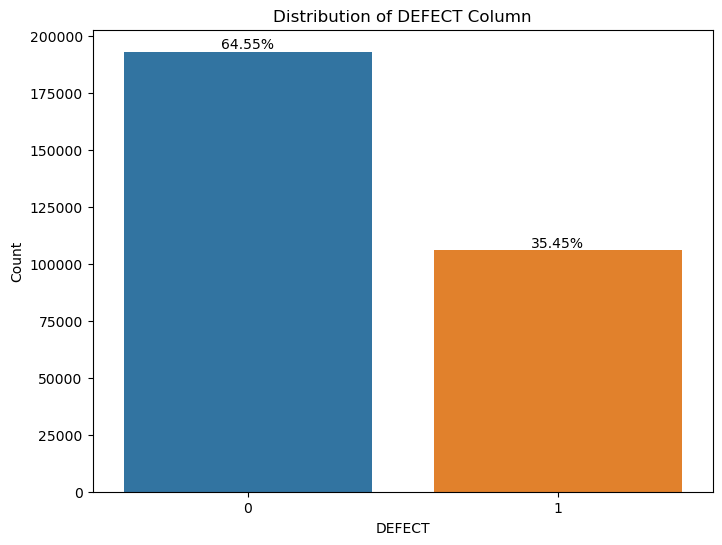

In [198]:
total_count = len(merged_df)
defect_counts = merged_df['DEFECT'].value_counts()
defect_percentages = [count / total_count * 100 for count in defect_counts]

# Plot the distribution of the 'DEFECT' column
plt.figure(figsize=(8, 6))
sns.countplot(data=merged_df, x='DEFECT')
plt.title('Distribution of DEFECT Column')
plt.xlabel('DEFECT')
plt.ylabel('Count')

# Add percentage annotations
for i, percentage in enumerate(defect_percentages):
    plt.text(i, defect_counts[i], f'{percentage:.2f}%', ha='center', va='bottom')

plt.show()


### Dropping NaN values

In [6]:
# nan_counts = merged_df.isnull().sum()
# columns_with_nans = nan_counts[nan_counts > 0].index.tolist()
# dropped_df = merged_df.dropna(subset=columns_with_nans)
# dropped_df

,COIL,DATE,MT_REVIEWED,TIME_START_PROCESS,SPEED_PROCESS,TEMP_Z1,TEMP_Z2,TEMP_Z3,TEMP_Z4,TEMP_Z5,...,FILL_ALL,FILL_BENDING_POS,FILL_BENDING_NEG,DIF_TIPO_1,DIF_TIPO_2,DIF_TIPO_3,DIF_TIPO_4,DIF_TIPO_5,DIF_TIPO_6,DEFECT
170,243941,2019-03-06,28,00:02:59.070,23.610352,1273.28850,1279.944000,1281.003750,1280.850750,1313.777250,...,0.035063,0.258854,0.134993,0,0,0,0,0,0,0
171,243941,2019-03-06,35,00:03:14.070,23.570531,1272.81000,1280.896875,1282.756875,1280.227500,1310.394375,...,0.026615,0.258924,0.135011,0,0,0,0,0,0,0
172,243941,2019-03-06,42,00:03:44.070,23.591655,1272.04650,1280.596500,1283.728500,1280.731500,1309.549500,...,0.034612,0.258888,0.135006,0,0,0,0,0,0,0
173,243941,2019-03-06,49,00:03:59.070,23.583060,1270.78875,1279.190250,1284.021000,1280.661750,1308.818250,...,0.039367,0.258924,0.135024,0,0,0,0,0,0,0
174,243941,2019-03-06,56,00:04:14.070,23.594212,1269.96750,1277.968125,1284.232500,1281.303750,1308.823125,...,0.038277,0.258899,0.135018,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299365,6838679,2019-04-19,749,10:46:32.860,8.932843,1271.34000,1277.043750,1259.679375,1262.975625,1276.233750,...,0.034937,0.258947,0.135017,0,0,0,0,0,0,0
299366,6838679,2019-04-19,756,10:47:32.860,8.948430,1267.99875,1278.011250,1261.586250,1267.042500,1278.022500,...,0.038531,0.258911,0.134953,0,0,0,0,0,0,0
299367,6838679,2019-04-19,763,10:48:17.860,8.951884,1269.88875,1279.816875,1264.786875,1270.957500,1283.366250,...,0.038778,0.258913,0.135053,0,0,0,0,0,0,0
299368,6838679,2019-04-19,770,10:49:17.860,8.977444,1266.59250,1280.936250,1265.782500,1271.475000,1285.683750,...,0.035091,0.258892,0.135005,0,0,0,0,0,0,0


In [6]:
X=merged_df.loc[:, 'SPEED_PROCESS':'FILL_BENDING_NEG']
print(X.shape)
X.head()

(299384, 106)


,SPEED_PROCESS,TEMP_Z1,TEMP_Z2,TEMP_Z3,TEMP_Z4,TEMP_Z5,TEMP_Z6,PYRO_1_PRECHMBR,PYRO_2_FRST_3_ZONE,PYRO_3_LST_3_ZONE,...,SPZ2_R4,SPZ1_R1_ASS,SPZ1_R2_ASS,TIRO_DECAP,SPEED_FILL,FILL_FORZA,FILL_TIRO,FILL_ALL,FILL_BENDING_POS,FILL_BENDING_NEG
0,16.934625,671.967562,679.751438,688.119187,716.717250,734.616563,734.603062,549.3825,667.890562,548.112375,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,16.773638,668.635875,676.207125,681.034500,710.093250,729.040500,727.025625,549.3825,668.464875,548.112375,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11.142165,669.105375,677.042625,678.493125,707.967750,727.783500,724.035750,549.3825,667.828500,548.112375,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11.148851,671.631750,681.066000,679.704750,707.241375,727.886250,723.072375,549.3825,675.487125,548.112375,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,15.657188,675.052875,686.972813,683.336250,710.432437,730.182375,724.168688,549.3825,696.461625,567.477562,...,530.110125,14.625,14.625,1956.40875,NaN,NaN,NaN,NaN,NaN,NaN


Dropping columns with 0 variance

## DROPPING FEATURES with correlation

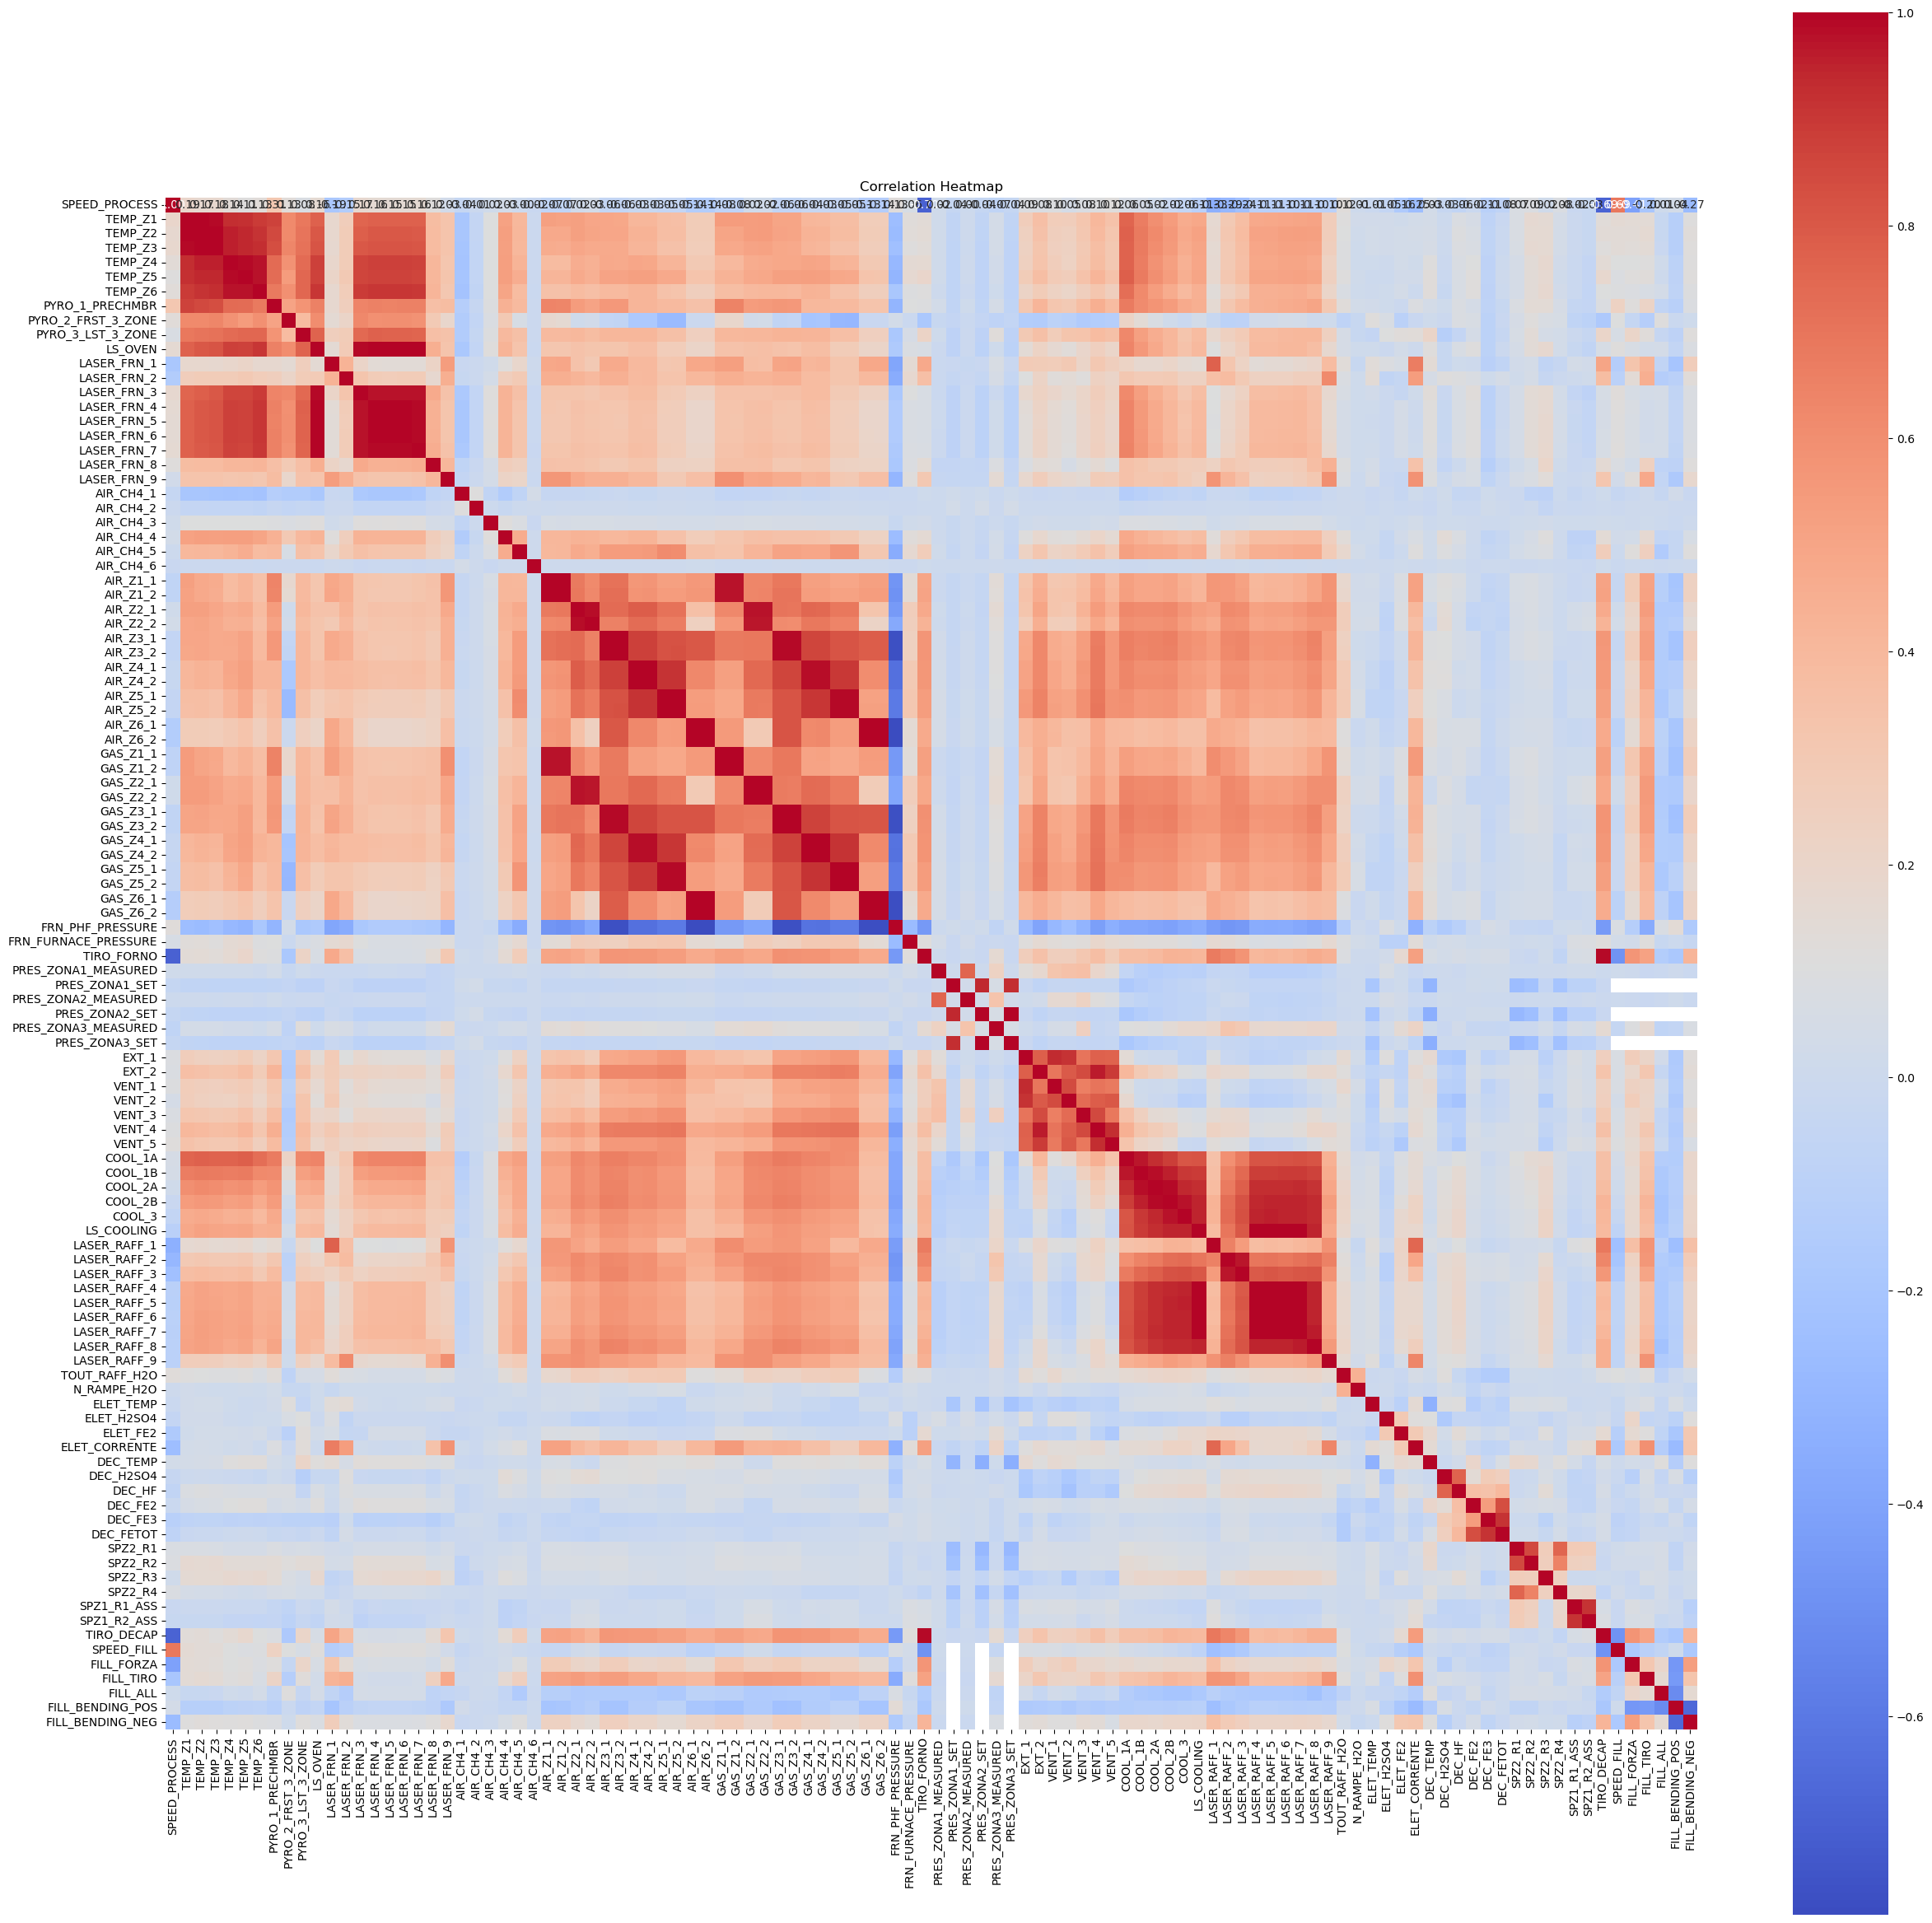

In [7]:
corr_matrix = X.corr()
plt.figure(figsize=(30, 30))  # You can adjust the size as needed
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Correlation Heatmap')
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

In [113]:
corr_matrix = X.corr().abs()  # Take absolute value to consider both positive and negative correlations

# Step 2: Set a correlation threshold
threshold = .75

# Step 3: Identify highly correlated pairs
# We use a mask to avoid duplication and self-correlation (correlation of a feature with itself)
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Step 4: Choose features to drop (we'll drop one of each pair)
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]

# Step 5: Drop the features
X_reduced = X.drop(columns=to_drop)
# X_reduced = X_reduced.drop(['PRES_ZONA3_SET', 'PRES_ZONA1_SET', 'PRES_ZONA2_SET'], axis=1)
X_reduced.shape

(299384, 43)

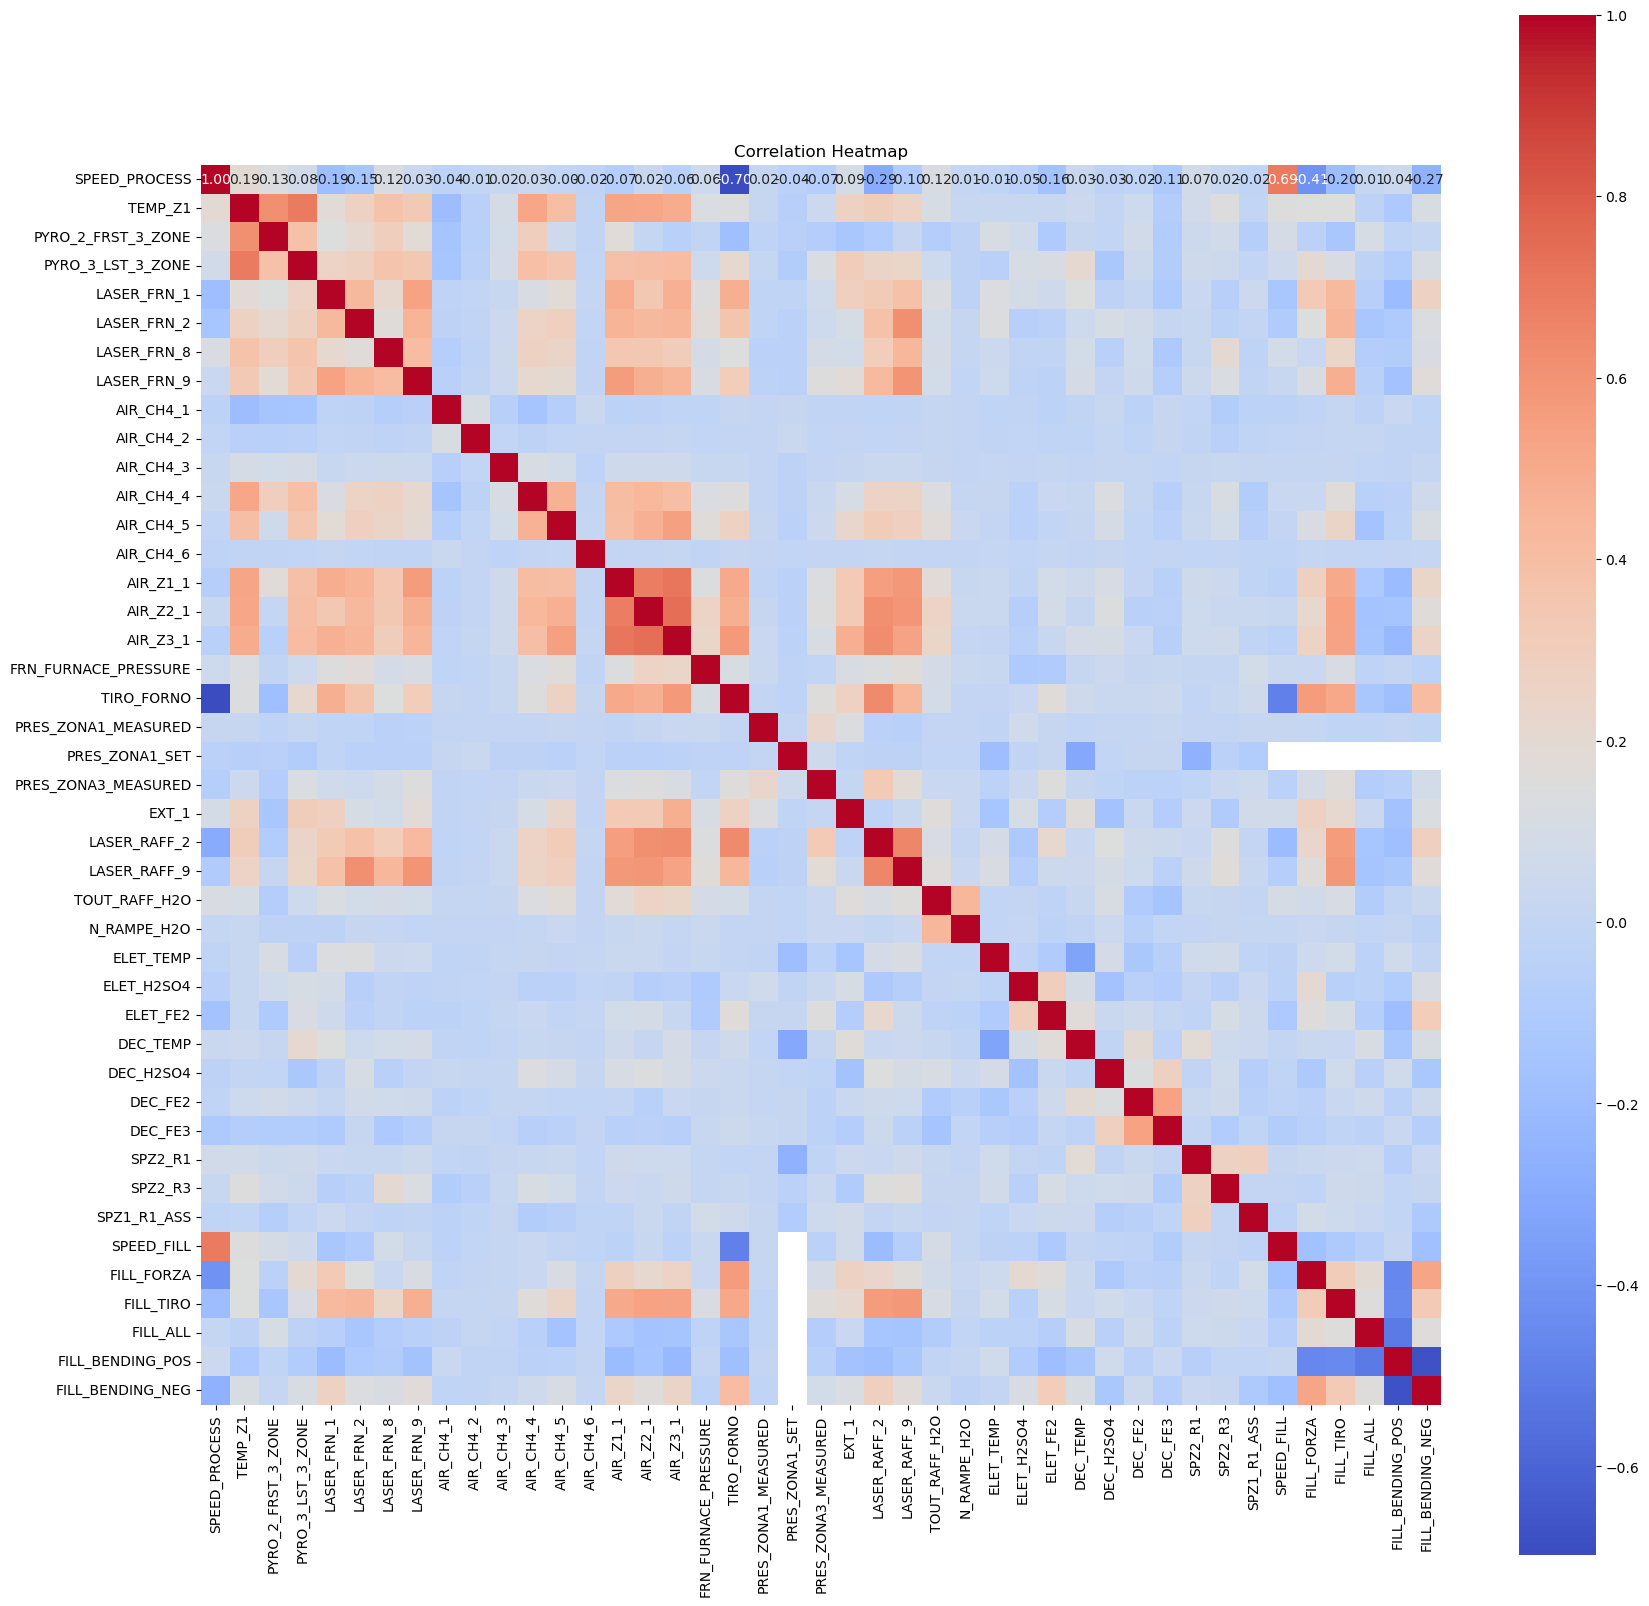

In [114]:
corr_matrix = X_reduced.corr()

# Create a heatmap
plt.figure(figsize=(20, 20))  # You can adjust the size as needed
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Correlation Heatmap')
plt.show()

## Splitting into Training, Validation and Test

In [115]:
target_columns = ['DEFECT']

X = X_reduced
# X=merged_df.loc[:, 'SPEED_PROCESS':'FILL_BENDING_NEG']
y = merged_df[target_columns]
print(X.shape)
print(y.shape)
grouped = merged_df.groupby('COIL').groups

grouped_indices = [grouped[key] for key in grouped]

train_indices, temp_indices = train_test_split(grouped_indices, test_size=0.4, random_state=random_state)

validate_indices, test_indices = train_test_split(temp_indices, test_size=0.5, random_state=random_state)

train_indices = [index for sublist in train_indices for index in sublist]
validate_indices = [index for sublist in validate_indices for index in sublist]
test_indices = [index for sublist in test_indices for index in sublist]

X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
X_val, y_val = X.iloc[validate_indices], y.iloc[validate_indices]
X_test, y_test = X.iloc[test_indices], y.iloc[test_indices]

(299384, 43)
(299384, 1)


In [116]:
coil_to_dataset = {}

for coil_id in merged_df['COIL'].unique():
    if coil_id in merged_df.loc[train_indices, 'COIL'].values:
        coil_to_dataset[coil_id] = 'train'
    elif coil_id in merged_df.loc[validate_indices, 'COIL'].values:
        coil_to_dataset[coil_id] = 'validate'
    elif coil_id in merged_df.loc[test_indices, 'COIL'].values:
        coil_to_dataset[coil_id] = 'test'
from collections import defaultdict
coil_datasets = defaultdict(list)

for coil_id, dataset in coil_to_dataset.items():
    coil_datasets[coil_id].append(dataset)
duplicates = {coil_id: datasets for coil_id, datasets in coil_datasets.items() if len(datasets) > 1}
if duplicates:
    print("Duplicate COIL IDs found in multiple datasets:", duplicates)
else:
    print("No duplicate COIL IDs found. The split is correct.")


No duplicate COIL IDs found. The split is correct.


In [121]:
print('There are {} samples in the training dataset which represent the {:.2f}%'.format(X_train.shape[0], X_train.shape[0]/merged_df.shape[0]*100))
print("There are {} samples in the validating dataset which represent the {:.2f}%".format(X_val.shape[0], X_val.shape[0]/merged_df.shape[0]*100))
print("There are {} samples in the testing dataset which represent the {:.2f}%".format(X_test.shape[0], X_test.shape[0]/merged_df.shape[0]*100))
print("Each sample has {} features".format(X_train.shape[1]))
print(f"Unique COIL values in 'production' dataset: {production['COIL'].nunique()}")
print(f"Unique COIL values in 'merged_df' dataset: {merged_df['COIL'].nunique()}")
train_indices = X_train.index
train_coils = merged_df.loc[train_indices, 'COIL']
unique_coils_in_train = train_coils.unique()
print(f"Number of unique COILs in X_train: {len(unique_coils_in_train)}")
val_indices = X_val.index
val_coils = merged_df.loc[val_indices, 'COIL']
unique_coils_in_val = val_coils.unique()
print(f"Number of unique COILs in X_train: {len(unique_coils_in_val)}")
test_indices = X_test.index
test_coils = merged_df.loc[test_indices, 'COIL']
unique_coils_in_test = test_coils.unique()
print(f"Number of unique COILs in X_train: {len(unique_coils_in_test)}")

There are 179813 samples in the training dataset which represent the 60.06%
There are 56625 samples in the validating dataset which represent the 18.91%
There are 62946 samples in the testing dataset which represent the 21.03%
Each sample has 43 features
Unique COIL values in 'production' dataset: 1261
Unique COIL values in 'merged_df' dataset: 1261
Number of unique COILs in X_train: 756
Number of unique COILs in X_train: 252
Number of unique COILs in X_train: 253


### Binary target
Random Search CV

In [156]:
# Define the list of model labels you want to use
model_lbls = ['dt', 'rf', 'xgb']

# Define the models and hyperparameter grids
models = {
    'dt': {'name': 'Decision Tree       ',
           'estimator': DecisionTreeClassifier(random_state=random_state), 
           'param': [{'max_depth': [*range(1,20)], 
                      'min_samples_split': [2, 5],
                      'min_samples_leaf': [1, 2],
                      'max_features': ['sqrt', 'log2', None],
                      'class_weight':[None, 'balanced']}],
          },
    'rf': {'name': 'Random Forest       ',
           'estimator': RandomForestClassifier(random_state=random_state),
           'param': [{'max_depth': [None, 5],
                      'min_samples_split': [2],
                      'min_samples_leaf': [1],
                      'n_estimators':[10,50]}]
          },
    'xgb': {'name': 'XGBoost            ',
            'estimator': XGBClassifier(random_state=random_state),
            'param': [{'n_estimators': [100, 200],
                       'learning_rate': [0.1, 0.2],
                       'max_depth': [3, 5],
                       'subsample': [0.8, 0.9]}]
           }
}
# Define the scoring metrics
scorings = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

# Initialize results DataFrame
results = pd.DataFrame(columns=['scoring', 'model', 'best_params',
                                'accuracy', 'precision_macro', 'recall_macro', 'f1_macro'])

# Perform GridSearchCV for each model and scoring metric
for scoring in scorings:
    for m in model_lbls:
        clf = GridSearchCV(models[m]['estimator'], models[m]['param'], cv=cv,
                           scoring=scoring, n_jobs=-1)
        clf.fit(X_train, y_train.to_numpy().ravel())
        y_true, y_pred = y_val, clf.predict(X_val)
        cr = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
        results.loc[len(results)] = [scoring, models[m]['name'], clf.best_params_,
                                     cr['accuracy'],
                                     cr['macro avg']['precision'],
                                     cr['macro avg']['recall'],
                                     cr['macro avg']['f1-score']]

# Display the results
for score in scorings:
    scoring_filter = score
    display(results[results.scoring == scoring_filter]
            .sort_values(by=scoring_filter, ascending=False)
            .drop('scoring', axis=1)
            .style.format(precision=3)
            .set_caption(f'Results for scoring "{scoring_filter}"'))

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-pa

,model,best_params,accuracy,precision_macro,recall_macro,f1_macro
2,XGBoost,"{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9}",0.755,0.742,0.733,0.736
1,Random Forest,"{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}",0.753,0.740,0.728,0.732
0,Decision Tree,"{'class_weight': 'balanced', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}",0.712,0.707,0.719,0.707


,model,best_params,accuracy,precision_macro,recall_macro,f1_macro
5,XGBoost,"{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9}",0.755,0.742,0.733,0.736
4,Random Forest,"{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}",0.753,0.740,0.728,0.732
3,Decision Tree,"{'class_weight': 'balanced', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}",0.712,0.707,0.719,0.707


,model,best_params,accuracy,precision_macro,recall_macro,f1_macro
8,XGBoost,"{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9}",0.755,0.742,0.733,0.736
7,Random Forest,"{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}",0.753,0.740,0.728,0.732
6,Decision Tree,"{'class_weight': 'balanced', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}",0.712,0.707,0.719,0.707


,model,best_params,accuracy,precision_macro,recall_macro,f1_macro
11,XGBoost,"{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9}",0.755,0.742,0.733,0.736
10,Random Forest,"{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}",0.753,0.740,0.728,0.732
9,Decision Tree,"{'class_weight': 'balanced', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}",0.712,0.707,0.719,0.707


In [162]:
# Evaluate the model on the test set
best_model_sc = clf.best_estimator_
test_predictions = best_model_sc.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
test_recall = recall_score(y_test, test_predictions, average='macro')
test_precision = precision_score(y_test, test_predictions, average='macro')
test_f1 = f1_score(y_test, test_predictions, average='macro')

print("Test Accuracy:", test_accuracy)
print("Test Recall:", test_recall)
print("Test Precision:", test_precision)
print("Test F1 Score:", test_f1)

# Confusion Matrix for the test set
test_confusion_matrix = confusion_matrix(y_test, test_predictions)
print("Test Confusion Matrix:\n", test_confusion_matrix)

Test Accuracy: 0.8217678645187939
Test Recall: 0.7963647998208719
Test Precision: 0.7971568772470732
Test F1 Score: 0.7967577818836973
Test Confusion Matrix:
 [[36904  5557]
 [ 5662 14823]]


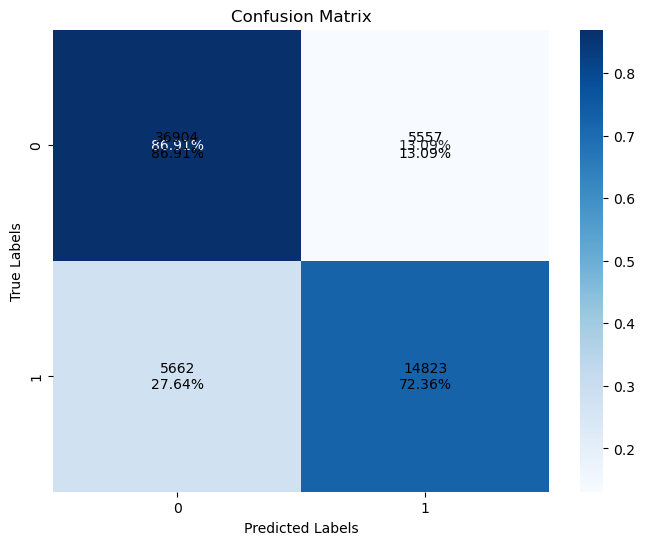

In [175]:
# Calculate percentages
conf_matrix_percent = test_confusion_matrix / test_confusion_matrix.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix with annotations and color bar
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt='.2%', cmap='Blues', cbar=True)

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Add annotations for TP, FP, TN, FN
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        if i == 0 and j == 0:  # TN cell
            plt.text(j + 0.5, i + 0.5, f'{conf_matrix[i, j]}\n{conf_matrix_percent[i, j]:.2%}', ha='center', va='center', color='black', fontsize=10)
        elif i == 1 and j == 0:  # FN cell
            plt.text(j + 0.5, i + 0.5, f'{conf_matrix[i, j]}\n{conf_matrix_percent[i, j]:.2%}', ha='center', va='center', color='black', fontsize=10)
        elif i == 1 and j == 1:  # TP cell
            plt.text(j + 0.5, i + 0.5, f'{conf_matrix[i, j]}\n{conf_matrix_percent[i, j]:.2%}', ha='center', va='center', color='black', fontsize=10)
        else:  # Other cells
            plt.text(j + 0.5, i + 0.5, f'{conf_matrix[i, j]}\n{conf_matrix_percent[i, j]:.2%}', ha='center', va='center', color='black', fontsize=10)

plt.show()


In [132]:
param_dist = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.2],
    'max_depth': [3, 5],
    'subsample': [0.8, 0.9],
}
xgb_classifier = XGBClassifier(random_state=random_state)
random_search = RandomizedSearchCV(
    estimator=xgb_classifier,
    param_distributions=param_dist,
    n_iter=10,  # Number of parameter settings that are sampled
    cv=3,  # Reduced number of cross-validation folds
    scoring='accuracy',
    n_jobs=-1,
    random_state=random_state,
    verbose=2
)
random_search.fit(X_train, y_train)
best_params = random_search.best_params_
best_score = random_search.best_score_
print(f"Best parameters: {best_params}")
print(f"Best cross-validated score: {best_score:.4f}")
best_model_random = random_search.best_estimator_
# Evaluate the model on the training set
train_predictions = best_model_random.predict(X_train)
train_accuracy = accuracy_score(y_train, train_predictions)
train_recall = recall_score(y_train, train_predictions, average='macro')
train_precision = precision_score(y_train, train_predictions, average='macro')
train_f1 = f1_score(y_train, train_predictions, average='macro')

print("Train Accuracy:", train_accuracy)
print("Train Recall:", train_recall)
print("Train Precision:", train_precision)
print("Train F1 Score:", train_f1)

# Evaluate the model on the validation set
val_predictions = best_model_random.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)
val_recall = recall_score(y_val, val_predictions, average='macro')
val_precision = precision_score(y_val, val_predictions, average='macro')
val_f1 = f1_score(y_val, val_predictions, average='macro')

print("Validation Accuracy:", val_accuracy)
print("Validation Recall:", val_recall)
print("Validation Precision:", val_precision)
print("Validation F1 Score:", val_f1)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.9; total time=   1.8s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.9; total time=   1.9s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.9s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.9; total time=   1.9s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   2.0s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   2.1s
[CV] END learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.9; total time=   2.4s
[CV] END learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.9; total time=   2.5s
[CV] END learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.9; total time=   2.6s
[CV] END learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.8; total time=   4.2s
[CV] END 

In [131]:
# Evaluate the model on the training set
train_predictions = best_model_random.predict(X_train)
train_accuracy = accuracy_score(y_train, train_predictions)
train_recall = recall_score(y_train, train_predictions, average='macro')
train_precision = precision_score(y_train, train_predictions, average='macro')
train_f1 = f1_score(y_train, train_predictions, average='macro')

print("Train Accuracy:", train_accuracy)
print("Train Recall:", train_recall)
print("Train Precision:", train_precision)
print("Train F1 Score:", train_f1)

# Evaluate the model on the validation set
val_predictions = best_model_random.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)
val_recall = recall_score(y_val, val_predictions, average='macro')
val_precision = precision_score(y_val, val_predictions, average='macro')
val_f1 = f1_score(y_val, val_predictions, average='macro')

print("Validation Accuracy:", val_accuracy)
print("Validation Recall:", val_recall)
print("Validation Precision:", val_precision)
print("Validation F1 Score:", val_f1)

# Evaluate the model on the test set
test_predictions = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
test_recall = recall_score(y_test, test_predictions, average='macro')
test_precision = precision_score(y_test, test_predictions, average='macro')
test_f1 = f1_score(y_test, test_predictions, average='macro')

print("Test Accuracy:", test_accuracy)
print("Test Recall:", test_recall)
print("Test Precision:", test_precision)
print("Test F1 Score:", test_f1)

# Confusion Matrix for the test set
test_confusion_matrix = confusion_matrix(y_test, test_predictions)
print("Test Confusion Matrix:\n", test_confusion_matrix)

Train Accuracy: 0.8912314460022357
Train Recall: 0.8817706935623957
Train Precision: 0.8811276973077289
Train F1 Score: 0.881447184285475
Validation Accuracy: 0.7553200883002208
Validation Recall: 0.7325800572927276
Validation Precision: 0.7421190168066315
Validation F1 Score: 0.7362988020922046


Defining the models to be proved

In [154]:
# Evaluate the model on the test set
test_predictions = best_model_grid.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
test_recall = recall_score(y_test, test_predictions, average='macro')
test_precision = precision_score(y_test, test_predictions, average='macro')
test_f1 = f1_score(y_test, test_predictions, average='macro')

print("Test Accuracy:", test_accuracy)
print("Test Recall:", test_recall)
print("Test Precision:", test_precision)
print("Test F1 Score:", test_f1)

# Confusion Matrix for the test set
test_confusion_matrix = confusion_matrix(y_test, test_predictions)
print("Test Confusion Matrix:\n", test_confusion_matrix)

Test Accuracy: 0.8217678645187939
Test Recall: 0.7963647998208719
Test Precision: 0.7971568772470732
Test F1 Score: 0.7967577818836973
Test Confusion Matrix:
 [[36904  5557]
 [ 5662 14823]]


In [176]:
results_df = pd.DataFrame(index=['TN', 'FP', 'FN', 'TP'], columns=defect_types)

# Iterate over each defect type
for defect_type in defect_types:
    # Extract the labels for the specific defect type from merged_df
    y_test_defect = merged_df.loc[test_indices, defect_type]
    
    # Compute the confusion matrix
    confusion_matrix_defect = confusion_matrix(y_test_defect, test_predictions)
    
    # Extract TP, TN, FP, FN values
    TN = confusion_matrix_defect[0, 0]
    FP = confusion_matrix_defect[0, 1]
    FN = confusion_matrix_defect[1, 0]
    TP = confusion_matrix_defect[1, 1]
    
    # Store the values in the results DataFrame
    results_df.loc['TN', defect_type] = TN
    results_df.loc['FP', defect_type] = FP
    results_df.loc['FN', defect_type] = FN
    results_df.loc['TP', defect_type] = TP

# Display the results DataFrame
results_df

,DIF_TIPO_1,DIF_TIPO_2,DIF_TIPO_3,DIF_TIPO_4,DIF_TIPO_5,DIF_TIPO_6
TN,42363,41100,38229,39445,42448,42332
FP,19276,19780,7037,12634,19904,18696
FN,203,1466,4337,3121,118,234
TP,1104,600,13343,7746,476,1684


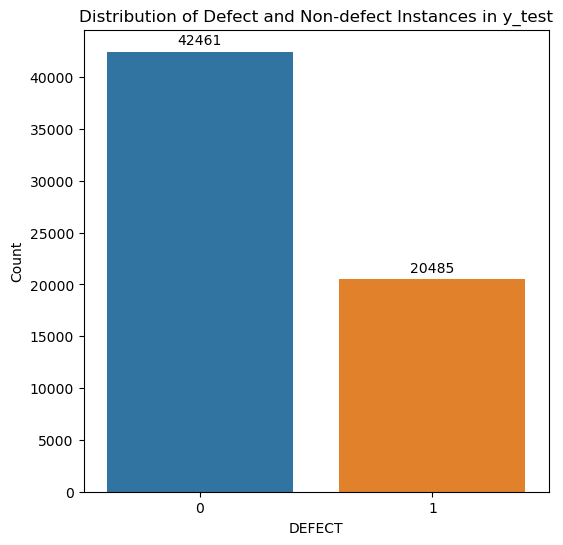

In [194]:
plt.figure(figsize=(6, 6))

ax = sns.countplot(data=merged_df.loc[test_indices], x='DEFECT', dodge=False)
plt.title('Distribution of Defect and Non-defect Instances in y_test')
plt.xlabel('DEFECT')
plt.ylabel('Count')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.0f}',  # Format to remove decimals
                xy=(p.get_x() + p.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.show()


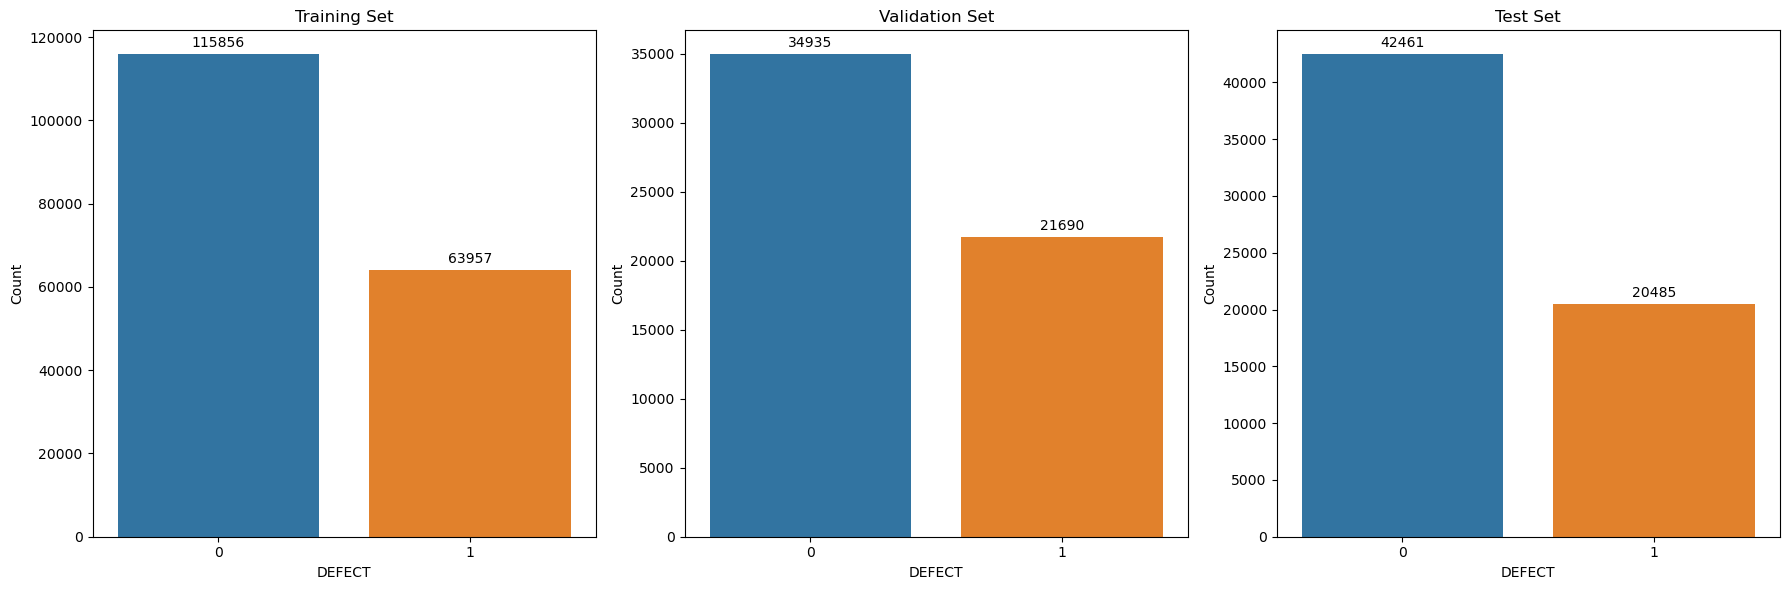

In [196]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot countplot for training set
sns.countplot(data=merged_df.loc[train_indices], x='DEFECT', ax=axes[0], dodge=False)
axes[0].set_title('Training Set')
axes[0].set_xlabel('DEFECT')
axes[0].set_ylabel('Count')
for p in axes[0].patches:
    height = p.get_height()
    axes[0].annotate(f'{height:.0f}', xy=(p.get_x() + p.get_width() / 2, height),
                     xytext=(0, 3), textcoords="offset points",
                     ha='center', va='bottom')

# Plot countplot for validation set
sns.countplot(data=merged_df.loc[val_indices], x='DEFECT', ax=axes[1], dodge=False)
axes[1].set_title('Validation Set')
axes[1].set_xlabel('DEFECT')
axes[1].set_ylabel('Count')
for p in axes[1].patches:
    height = p.get_height()
    axes[1].annotate(f'{height:.0f}', xy=(p.get_x() + p.get_width() / 2, height),
                     xytext=(0, 3), textcoords="offset points",
                     ha='center', va='bottom')

# Plot countplot for test set
sns.countplot(data=merged_df.loc[test_indices], x='DEFECT', ax=axes[2], dodge=False)
axes[2].set_title('Test Set')
axes[2].set_xlabel('DEFECT')
axes[2].set_ylabel('Count')
for p in axes[2].patches:
    height = p.get_height()
    axes[2].annotate(f'{height:.0f}', xy=(p.get_x() + p.get_width() / 2, height),
                     xytext=(0, 3), textcoords="offset points",
                     ha='center', va='bottom')

plt.tight_layout()
plt.show()


## Built-in Feature Importance
Most tree-based models in libraries like scikit-learn have a built-in feature_importances_ attribute after the model has been fitted. This provides a simple way to see the relative importance of each feature

In [178]:
feature_importances = best_model_sc.feature_importances_
f_sel=6
feature_importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)
print(f"The sum of all the features is {feature_importances_df['Importance'].sum()}")
print(f"The sum of importances for the top {f_sel} features is {feature_importances_df['Importance'].head(f_sel).sum()}")
feature_importances_df.head(10)


The sum of all the features is 1.0000001192092896
The sum of importances for the top 6 features is 0.36138463020324707


,Feature,Importance
1,TEMP_Z1,0.102561
23,LASER_RAFF_2,0.061827
2,PYRO_2_FRST_3_ZONE,0.060497
39,FILL_TIRO,0.055822
40,FILL_ALL,0.040647
16,AIR_Z3_1,0.040030
0,SPEED_PROCESS,0.036840
4,LASER_FRN_1,0.033820
35,SPZ2_R3,0.031163
24,LASER_RAFF_9,0.030477


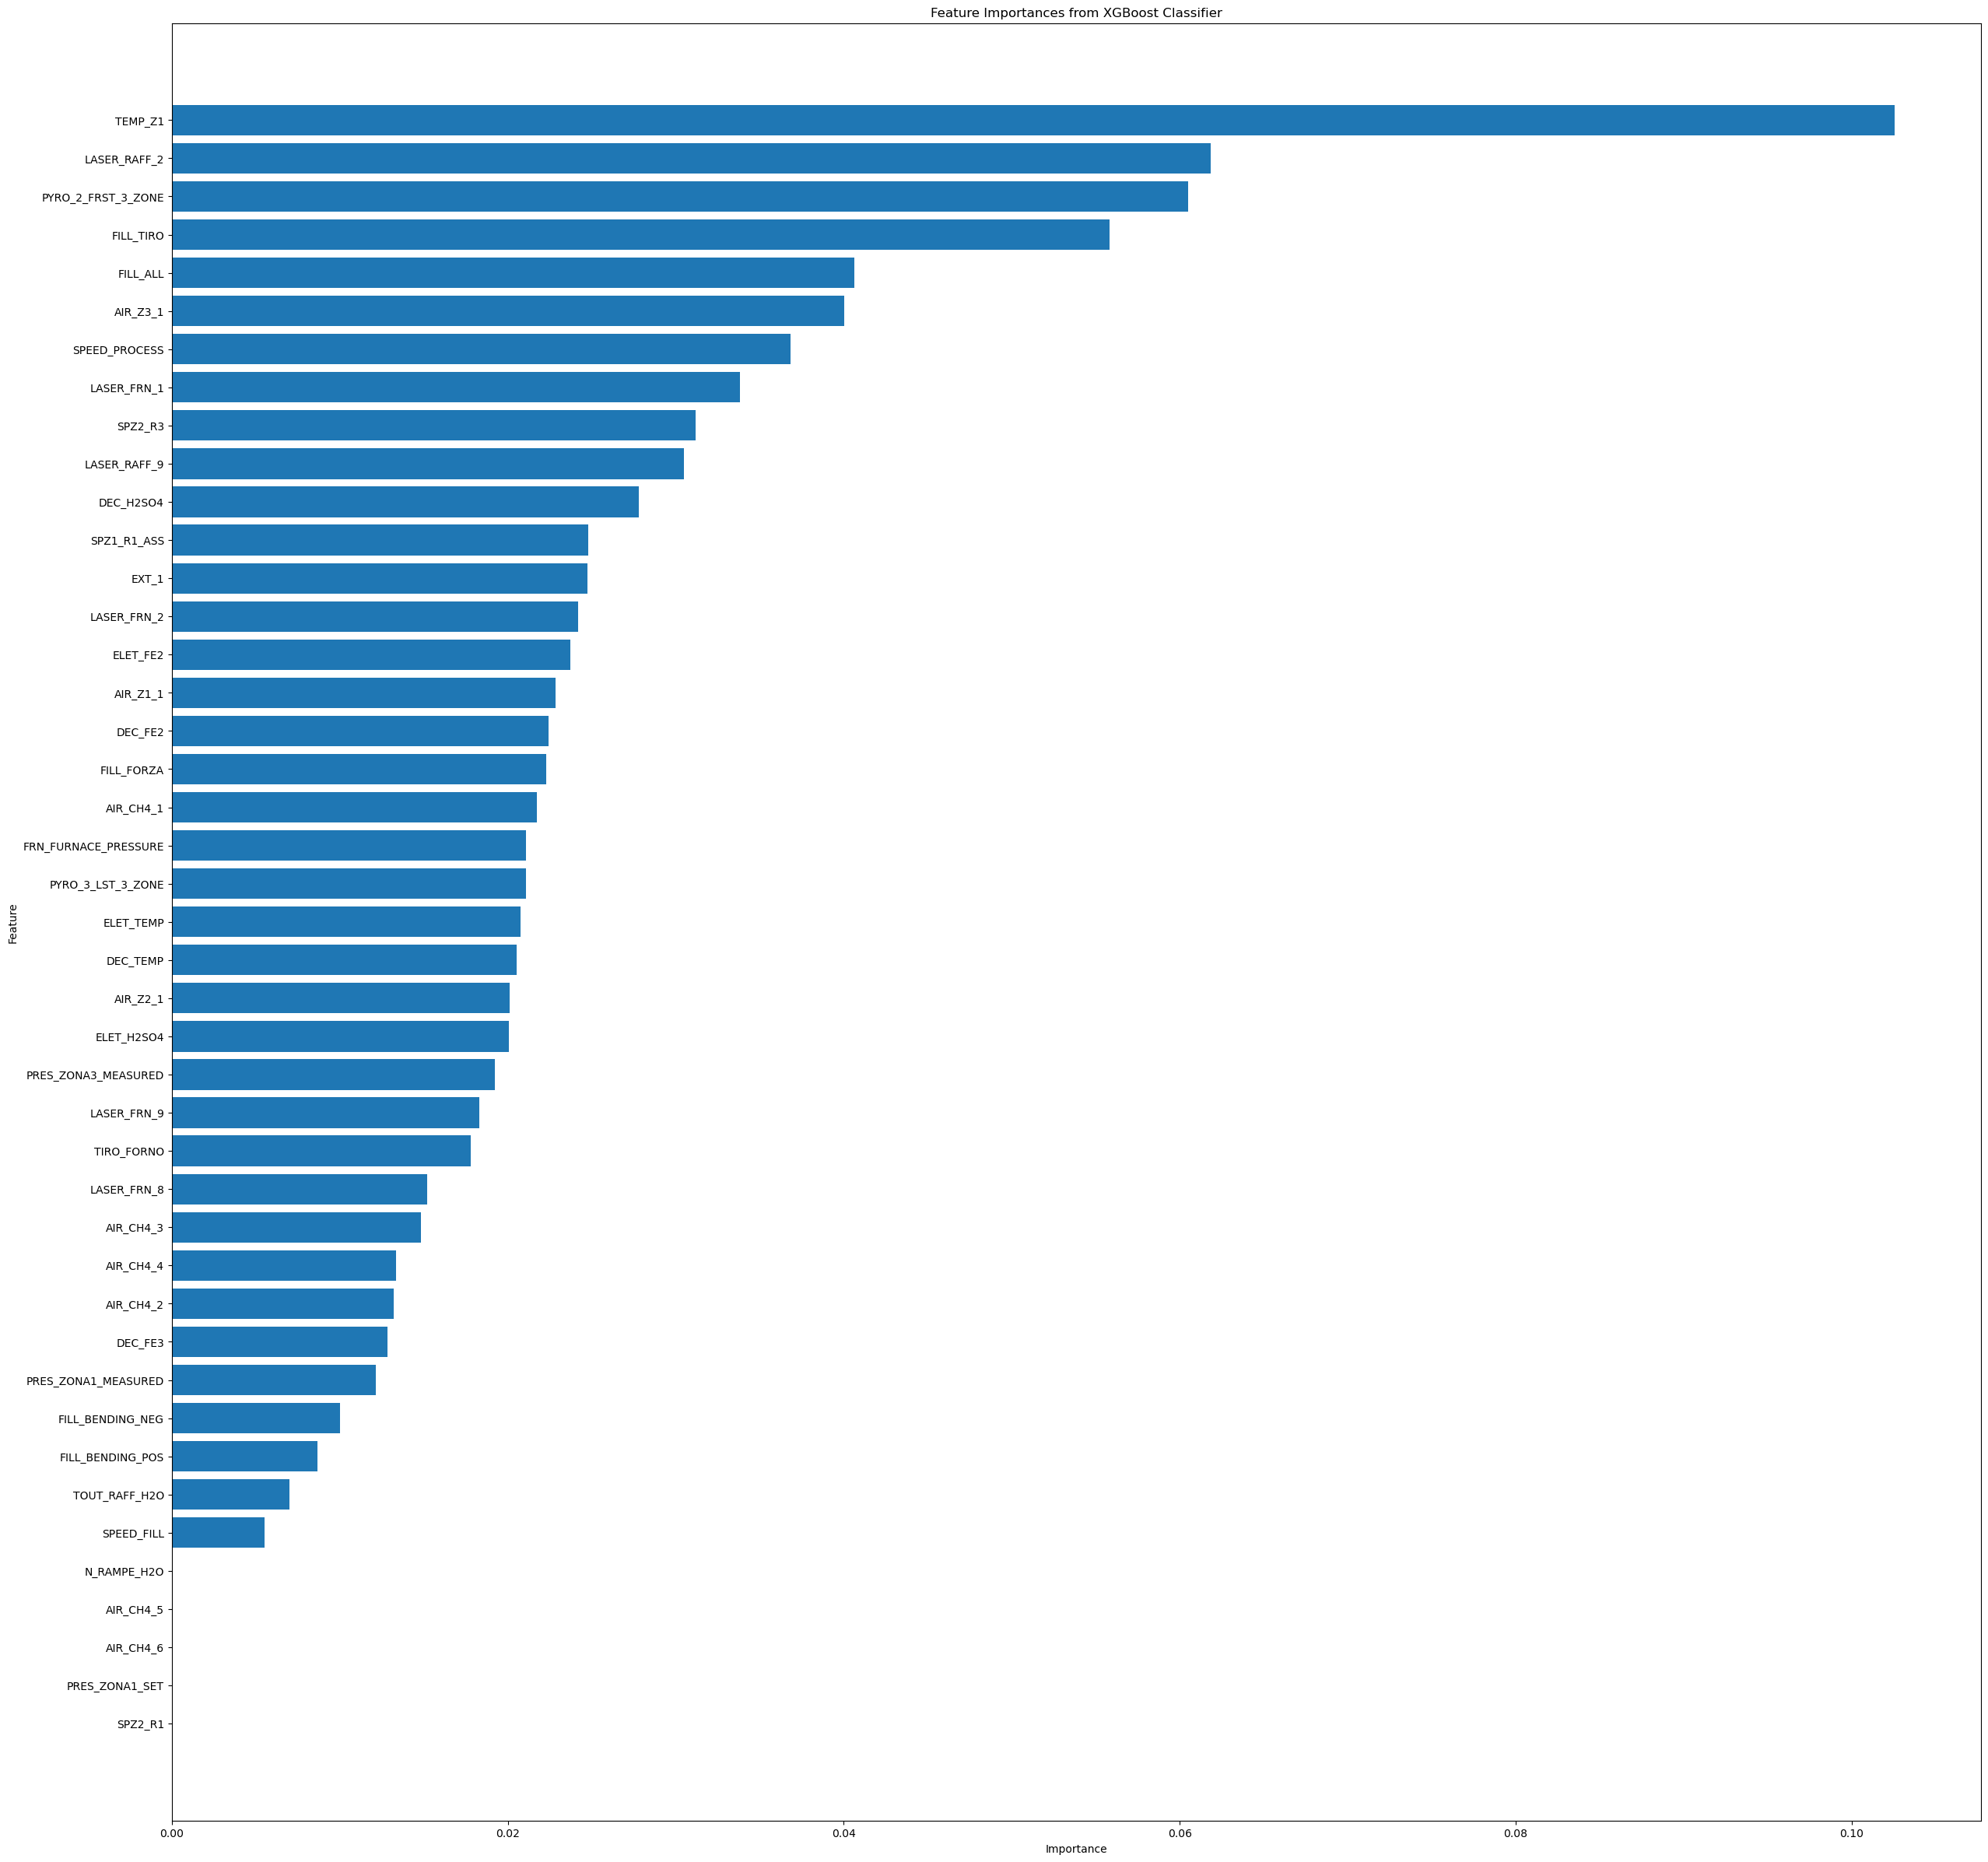

In [179]:
plt.figure(figsize=(30, 30))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from XGBoost Classifier')
plt.gca().invert_yaxis()
plt.show()

In [180]:
defects_df = merged_df[merged_df['DEFECT'] == 1]
print(defects_df.shape)
no_defects_df = merged_df[merged_df['DEFECT'] == 0]
print(no_defects_df.shape)

(106132, 117)
(193252, 117)


In [181]:
# Assuming 'feature_importances_df' is sorted by importance in descending order
# Get the names of the top 6 features
top_features = feature_importances_df['Feature'].head(f_sel)

# Initialize a dictionary to hold the statistics for each feature
feature_stats = {'Statistic': ['Min', 'Max', 'Mean', 'Median', 'Mode']}

# Define a function to calculate statistics for a given DataFrame and feature
def calculate_stats(df, feature):
    min_value = df[feature].min()
    max_value = df[feature].max()
    mean_value = df[feature].mean()
    median_value = df[feature].median()
    mode_value = df[feature].mode()[0]  # Mode could be multiple values; take the first one
    return [min_value, max_value, mean_value, median_value, mode_value]

# Loop over the top 6 features to calculate statistics for both DataFrames
for feature in top_features:
    feature_stats[f'{feature} No Defects'] = calculate_stats(no_defects_df, feature)
    feature_stats[f'{feature} Defects'] = calculate_stats(defects_df, feature)

# Create a DataFrame from the dictionary of statistics
stats_df = pd.DataFrame(feature_stats)

# Display the DataFrame
stats_df

,Statistic,TEMP_Z1 No Defects,TEMP_Z1 Defects,LASER_RAFF_2 No Defects,LASER_RAFF_2 Defects,PYRO_2_FRST_3_ZONE No Defects,PYRO_2_FRST_3_ZONE Defects,FILL_TIRO No Defects,FILL_TIRO Defects,FILL_ALL No Defects,FILL_ALL Defects,AIR_Z3_1 No Defects,AIR_Z3_1 Defects
0,Min,79.722742,262.855125,22.500000,22.500000,549.38250,549.382500,-48.285825,0.000000,0.000000,0.000000,-8.106604,-6.252772
1,Max,1322.268750,1320.543750,114.355125,110.429906,1411.74000,1374.318000,6052.078125,6257.584687,7.342893,3.328088,4183.503750,4129.998750
2,Mean,1223.142224,1260.480439,42.042764,50.418704,1153.32157,1135.527080,3418.034864,3940.182525,0.553756,0.496990,2025.511974,2730.349775
3,Median,1237.871250,1269.641250,41.816250,50.273309,1162.11375,1135.239107,3535.629231,4093.143750,0.561798,0.548785,2007.479532,2861.942813
4,Mode,1236.712500,1270.383750,22.500000,22.500000,549.38250,549.382500,0.000000,3364.301250,0.561386,0.562565,1483.976250,1483.200000


/var/folders/_0/7vfs2cbn3wlds_6c9t8rrhhm0000gn/T/ipykernel_61058/2646603015.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(no_defects_df[feature], shade=True, color='green', label='No Defects')
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/_0/7vfs2cbn3wlds_6c9t8rrhhm0000gn/T/ipykernel_61058/2646603015.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(defects_df[feature], shade=True, color='red', label='Defects')
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as

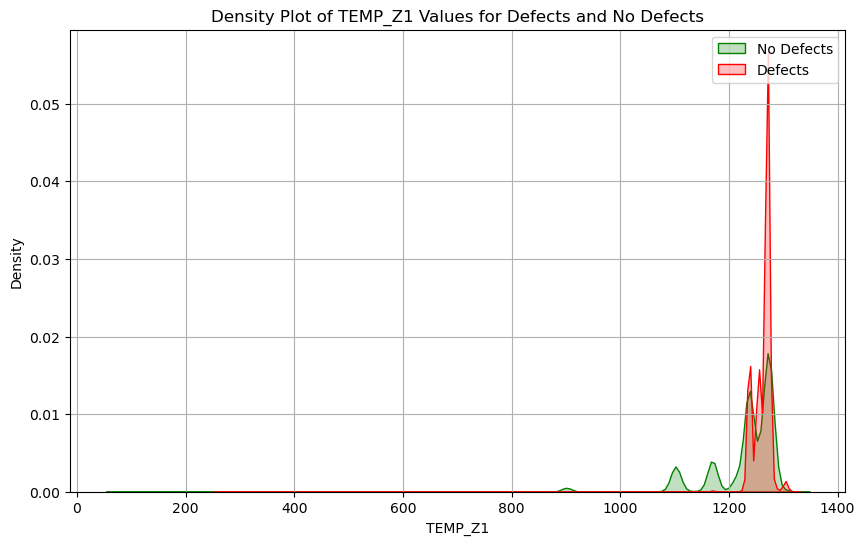

/var/folders/_0/7vfs2cbn3wlds_6c9t8rrhhm0000gn/T/ipykernel_61058/2646603015.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(no_defects_df[feature], shade=True, color='green', label='No Defects')
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/_0/7vfs2cbn3wlds_6c9t8rrhhm0000gn/T/ipykernel_61058/2646603015.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(defects_df[feature], shade=True, color='red', label='Defects')
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as

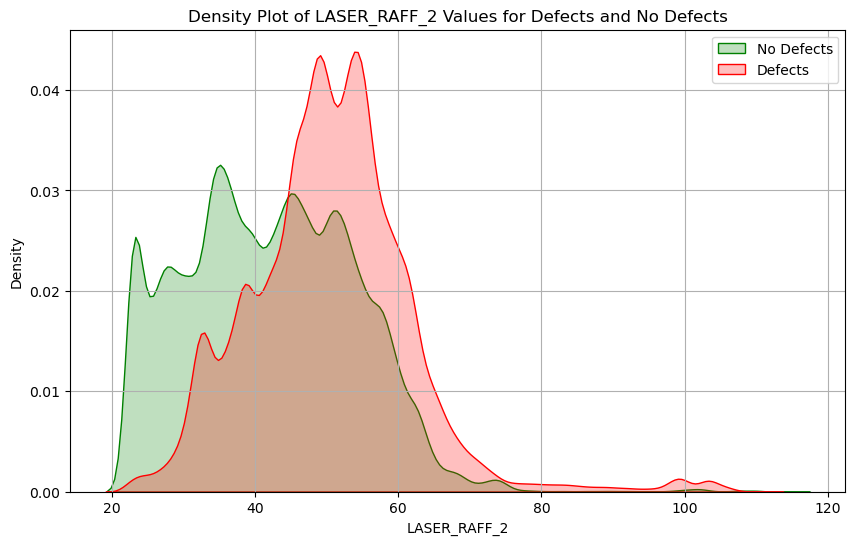

/var/folders/_0/7vfs2cbn3wlds_6c9t8rrhhm0000gn/T/ipykernel_61058/2646603015.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(no_defects_df[feature], shade=True, color='green', label='No Defects')
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/_0/7vfs2cbn3wlds_6c9t8rrhhm0000gn/T/ipykernel_61058/2646603015.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(defects_df[feature], shade=True, color='red', label='Defects')
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as

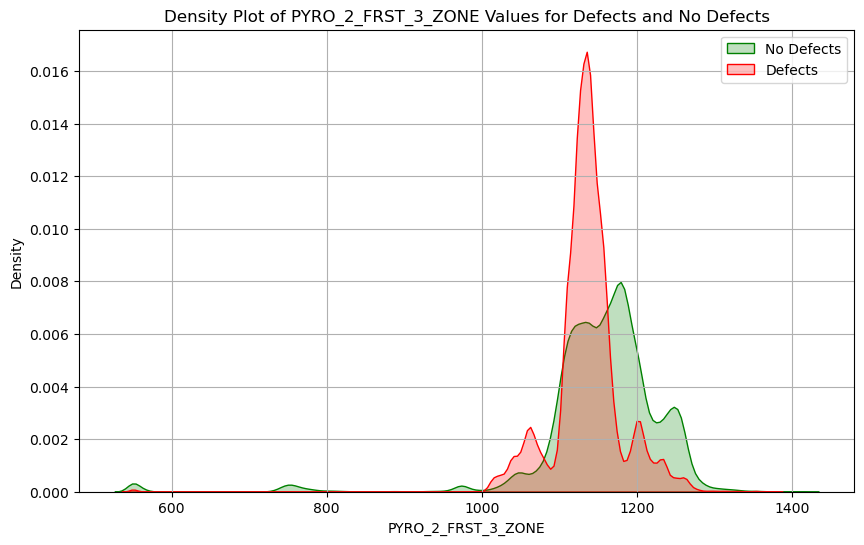

/var/folders/_0/7vfs2cbn3wlds_6c9t8rrhhm0000gn/T/ipykernel_61058/2646603015.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(no_defects_df[feature], shade=True, color='green', label='No Defects')
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/_0/7vfs2cbn3wlds_6c9t8rrhhm0000gn/T/ipykernel_61058/2646603015.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(defects_df[feature], shade=True, color='red', label='Defects')
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as

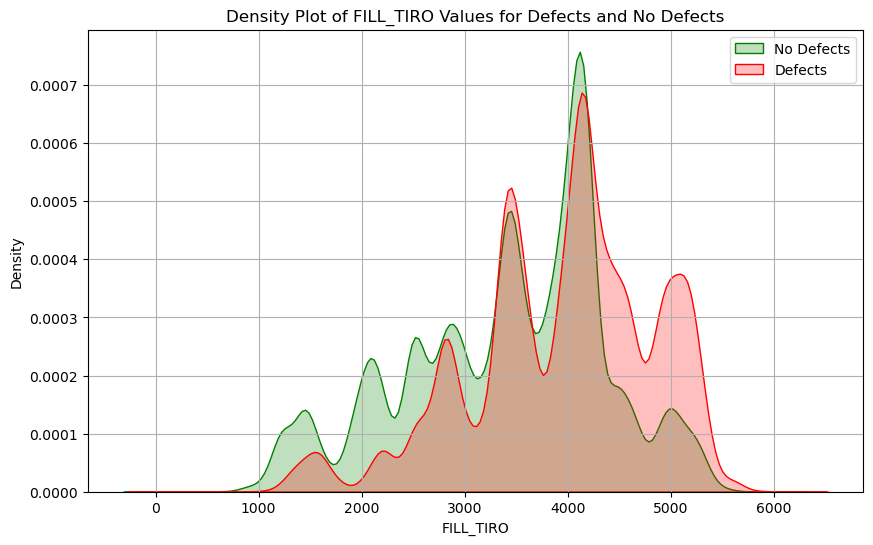

/var/folders/_0/7vfs2cbn3wlds_6c9t8rrhhm0000gn/T/ipykernel_61058/2646603015.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(no_defects_df[feature], shade=True, color='green', label='No Defects')
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/_0/7vfs2cbn3wlds_6c9t8rrhhm0000gn/T/ipykernel_61058/2646603015.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(defects_df[feature], shade=True, color='red', label='Defects')
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as

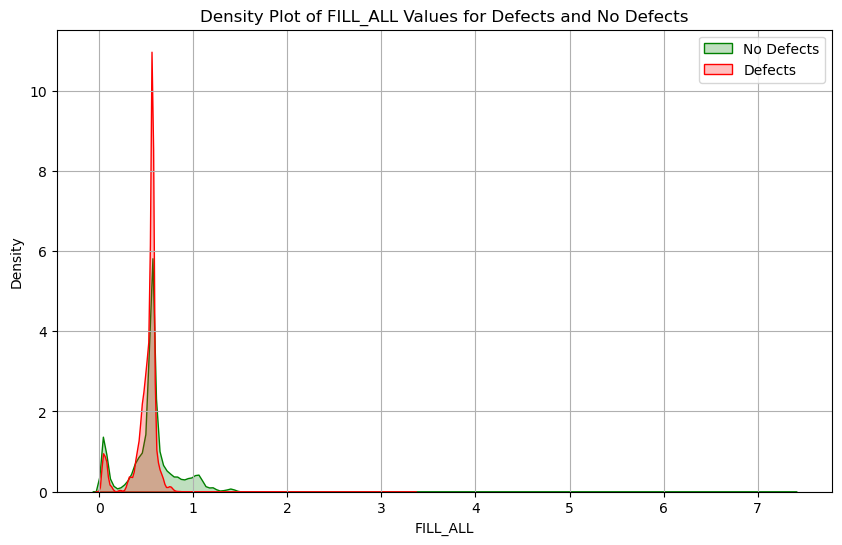

/var/folders/_0/7vfs2cbn3wlds_6c9t8rrhhm0000gn/T/ipykernel_61058/2646603015.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(no_defects_df[feature], shade=True, color='green', label='No Defects')
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/_0/7vfs2cbn3wlds_6c9t8rrhhm0000gn/T/ipykernel_61058/2646603015.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(defects_df[feature], shade=True, color='red', label='Defects')
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as

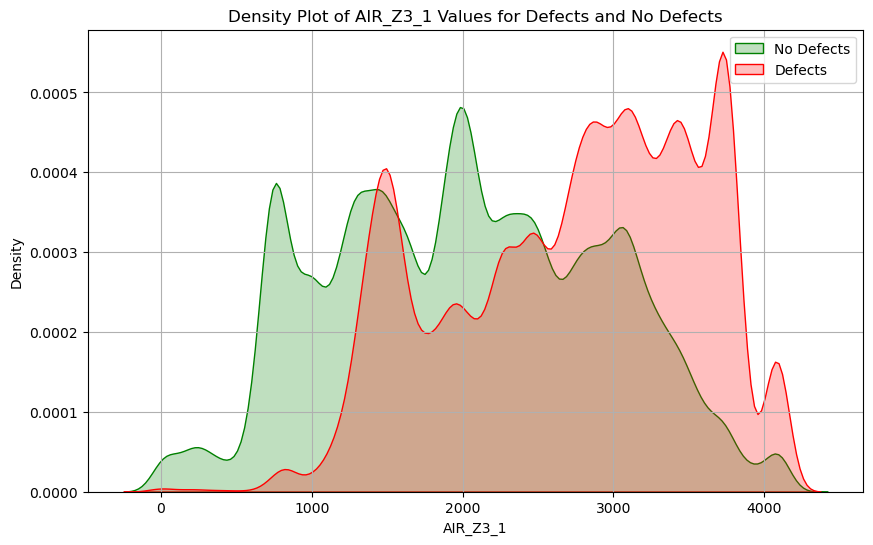

In [182]:
for feature in top_features:
    plt.figure(figsize=(10, 6))
    sns.kdeplot(no_defects_df[feature], shade=True, color='green', label='No Defects')
    sns.kdeplot(defects_df[feature], shade=True, color='red', label='Defects')
    plt.title(f'Density Plot of {feature} Values for Defects and No Defects')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()
